In [ ]:
!pip install -q gdown

In [ ]:
import gdown
import numpy as np
from keras.layers import Input, RandomContrast, RandomContrast, RandomTranslation,Flatten,Dropout
from keras.layers import Dense, Conv2D, Activation, MaxPooling2D, Rescaling, GlobalMaxPooling2D
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from typing import Tuple
import keras
from keras import layers
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import os
import random

In [ ]:

# TP1-3-natural-scenes.zip
gdown.download('https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ')

Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=e4eadc5e-a49a-4ae8-84df-7d9ca9e939c7
To: /content/TP1-3-natural-scenes.zip
100%|██████████| 363M/363M [00:02<00:00, 135MB/s]


'TP1-3-natural-scenes.zip'

In [ ]:
import zipfile

with zipfile.ZipFile('TP1-3-natural-scenes.zip', 'r') as zip_ref:
    zip_ref.extractall('./TP1-3')

In [ ]:
   gpus = tf.config.experimental.list_physical_devices("GPU")
   if gpus:
    try:
      for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu,True)
      logical_gpus=tf.config.experimental.list_logical_devices("GPU")
    except RuntimeError as e:
      print(e)

In [ ]:
TRAIN_DATA_FOLDER = Path("/content/TP1-3/seg_train/seg_train")
VAL_DATA_FOLDER = Path("/content/TP1-3/seg_test/seg_test")

BATCH_SIZE=32
IMG_H = 250
IMG_W = 250

In [ ]:
train_dataset=tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_FOLDER,
    label_mode="categorical",
    image_size=(IMG_H,IMG_W),
    batch_size=BATCH_SIZE
)

val_dataset=tf.keras.utils.image_dataset_from_directory(
    VAL_DATA_FOLDER,
    label_mode="categorical",
    image_size=(IMG_H,IMG_W),
    batch_size=BATCH_SIZE
)


Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [ ]:
count_dataset_classes=tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_FOLDER,
    label_mode="categorical",
    image_size=(IMG_H,IMG_W),
    batch_size=1  #1 porque debemos contar las imagenes
)

Found 14034 files belonging to 6 classes.


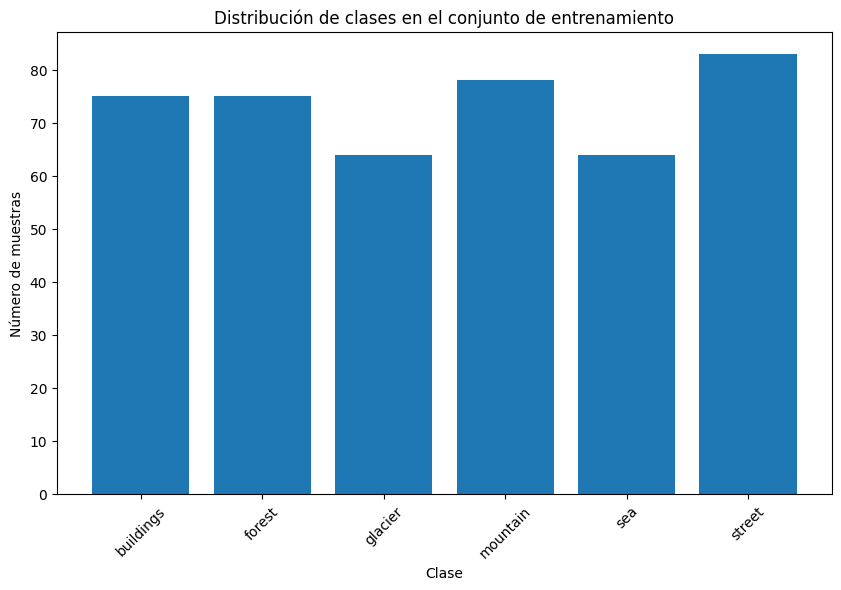

In [ ]:
# Obtener las etiquetas de las clases
class_names = train_dataset.class_names

# Inicializar un diccionario para contar las muestras en cada clase
class_counts = {class_name: 0 for class_name in class_names}

# Contar las muestras en cada clase
for images, labels in train_dataset:
    label_index = tf.argmax(labels, axis=1).numpy()[0]  # Obtener el índice de la clase
    class_counts[class_names[label_index]] += 1

# Visualizar la distribución de clases
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Distribución de clases en el conjunto de entrenamiento')
plt.xlabel('Clase')
plt.ylabel('Número de muestras')
plt.xticks(rotation=45)
plt.show()


In [ ]:
def procesar_imagen_prediccion(path: str) -> np.array:
    imagen = cv2.imread(path)
    imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    imagen_redimensionada = cv2.resize(imagen, (250, 250))
    imagen_para_prediccion = np.expand_dims(imagen_redimensionada, axis=0)

    return imagen_para_prediccion

def predecir_clase(path: str, modelo: tf.keras.Model) -> str:
    imagen_para_prediccion = procesar_imagen_prediccion(path)
    predicciones = modelo.predict(imagen_para_prediccion)

    clases = train_dataset.class_names
    diccionario_etiquetas = {0: clases[0], 1: clases[1], 2: clases[2], 3: clases[3], 4: clases[4], 5: clases[5]}

    indice_clase_max_probabilidad = np.argmax(predicciones, axis=1)
    etiqueta_predicha = diccionario_etiquetas[indice_clase_max_probabilidad[0]]

    return etiqueta_predicha, predicciones

In [ ]:
def predecir_y_mostrar_10_imagenes(folder_path: str, modelo: tf.keras.Model):
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    axs = axs.ravel()

    random_images = random.sample(os.listdir(folder_path), 10)

    for i, image_name in enumerate(random_images):
        image_path = os.path.join(folder_path, image_name)
        imagen_predicha, predicciones = predecir_clase(image_path, modelo)
        imagen = cv2.imread(image_path)
        imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

        axs[i].imshow(imagen)
        axs[i].set_title(f"Predicción: {imagen_predicha}")
        axs[i].axis('off')

    plt.show()


In [ ]:
def plot_training_history(history) -> plt:
    # Accuracy
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Pérdida
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.title('Pérdida')
    plt.xlabel('Epoch')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()


In [ ]:
EARLY_STOPPING = EarlyStopping(monitor="val_loss", patience=20, verbose=0, mode="min")

REDUCE_LR = ReduceLROnPlateau(
    monitor="loss",
    factor=0.5,
    patience=10,
    verbose=1,
    mode="min",
    min_delta=1e-4
)

Cantidad de clases en el dataset

In [ ]:
len(train_dataset.class_names)

6

In [ ]:
train_dataset.class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [ ]:
plt.figure(figsize=(10,10))
for images,labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(train_dataset.class_names[class_idx])
    plt.axis("off")


##Modelo de capas densas

In [ ]:
def dense_model(input_shape, output_label: int) -> tf.keras.Model:
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(units=32, activation="sigmoid"),
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dense(units=8, activation="sigmoid"),
        tf.keras.layers.Dense(units=output_label, activation="softmax")
    ])
    return model


In [ ]:
dense_model=dense_model(input_shape=(250,250,3),output_label=6)
dense_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 187500)            0         
                                                                 
 dense (Dense)               (None, 32)                6000032   
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 6)                 54        
                                                                 
Total params: 6002718 (22.90 MB)
Trainable params: 6002718 (22.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
dense_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history_dense_model = dense_model.fit(
    train_dataset,
    validation_data=val_dataset,  # Datos de validación
    epochs=150,
    batch_size=BATCH_SIZE,
    callbacks=[EARLY_STOPPING,REDUCE_LR]
)

Epoch 1/150
439/439 [==============================] - 33s 72ms/step - loss: 1.7956 - accuracy: 0.1703 - val_loss: 1.7925 - val_accuracy: 0.1750 - lr: 0.0010
Epoch 2/150
439/439 [==============================] - 31s 70ms/step - loss: 1.7919 - accuracy: 0.1764 - val_loss: 1.7921 - val_accuracy: 0.1750 - lr: 0.0010
Epoch 3/150
439/439 [==============================] - 29s 66ms/step - loss: 1.7917 - accuracy: 0.1741 - val_loss: 1.7919 - val_accuracy: 0.1750 - lr: 0.0010
Epoch 4/150
439/439 [==============================] - 28s 64ms/step - loss: 1.7917 - accuracy: 0.1707 - val_loss: 1.7920 - val_accuracy: 0.1750 - lr: 0.0010
Epoch 5/150
439/439 [==============================] - 29s 65ms/step - loss: 1.7917 - accuracy: 0.1706 - val_loss: 1.7918 - val_accuracy: 0.1750 - lr: 0.0010
Epoch 6/150
439/439 [==============================] - 29s 66ms/step - loss: 1.7915 - accuracy: 0.1736 - val_loss: 1.7918 - val_accuracy: 0.1750 - lr: 0.0010
Epoch 7/150
439/439 [==============================]

In [ ]:
print("Evaluate on test data")
results = dense_model.evaluate(val_dataset, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

Evaluate on test data
94/94 [==============================] - 3s 25ms/step - loss: 1.7902 - accuracy: 0.1750
test loss, test acc: [1.7901743650436401, 0.17499999701976776]


In [ ]:
plot_training_history(history_dense_model)

In [ ]:
predecir_y_mostrar_10_imagenes("/content/TP1-3/seg_pred/seg_pred",dense_model)

1/1 [==============================] - 0s 16ms/step


## Modelo con capas convolucionales y densas.


In [ ]:
def cnn_model(*, input_shape, labels) -> tf.keras.Model:
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape, dtype=tf.float32),
        tf.keras.layers.Rescaling(1./255),

        # Capas convolucionales y de pooling
        tf.keras.layers.Conv2D(8, (3, 3)),
        tf.keras.layers.Activation("relu"),

        tf.keras.layers.Conv2D(16, (3, 3)),
        tf.keras.layers.Activation("relu"),

        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(32, (3, 3)),
        tf.keras.layers.Activation("relu"),

        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, (3, 3)),
        tf.keras.layers.Activation("relu"),

        tf.keras.layers.MaxPooling2D((2, 2)),

        # Capas densas
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(labels),
        tf.keras.layers.Activation("softmax")
    ])

    return model


In [ ]:
model_cnn=cnn_model(input_shape=(IMG_H,IMG_W,3),labels=len(train_dataset.class_names))
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 248, 248, 8)       224       
                                                                 
 activation_13 (Activation)  (None, 248, 248, 8)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 246, 246, 16)      1168      
                                                                 
 activation_14 (Activation)  (None, 246, 246, 16)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 123, 123, 16)      0         
 g2D)                                                            
                                                        

In [ ]:
model_cnn.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history_cnn=model_cnn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=500,
    batch_size=BATCH_SIZE,
    callbacks=[EARLY_STOPPING,REDUCE_LR]
)

Epoch 1/500
439/439 [==============================] - 40s 76ms/step - loss: 0.9748 - accuracy: 0.6218 - val_loss: 0.7897 - val_accuracy: 0.7103 - lr: 0.0010
Epoch 2/500
439/439 [==============================] - 33s 74ms/step - loss: 0.6694 - accuracy: 0.7562 - val_loss: 0.6775 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/500
439/439 [==============================] - 32s 73ms/step - loss: 0.5450 - accuracy: 0.8056 - val_loss: 0.6427 - val_accuracy: 0.7797 - lr: 0.0010
Epoch 4/500
439/439 [==============================] - 28s 62ms/step - loss: 0.4351 - accuracy: 0.8445 - val_loss: 0.6279 - val_accuracy: 0.7817 - lr: 0.0010
Epoch 5/500
439/439 [==============================] - 26s 59ms/step - loss: 0.3492 - accuracy: 0.8701 - val_loss: 0.7039 - val_accuracy: 0.7737 - lr: 0.0010
Epoch 6/500
439/439 [==============================] - 26s 60ms/step - loss: 0.2642 - accuracy: 0.9027 - val_loss: 0.7563 - val_accuracy: 0.7653 - lr: 0.0010
Epoch 7/500
439/439 [==============================]

In [ ]:
print("Evaluate on test data")
results = model_cnn.evaluate(val_dataset, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

Evaluate on test data
94/94 [==============================] - 4s 35ms/step - loss: 1.1636 - accuracy: 0.7937
test loss, test acc: [1.16363525390625, 0.793666660785675]


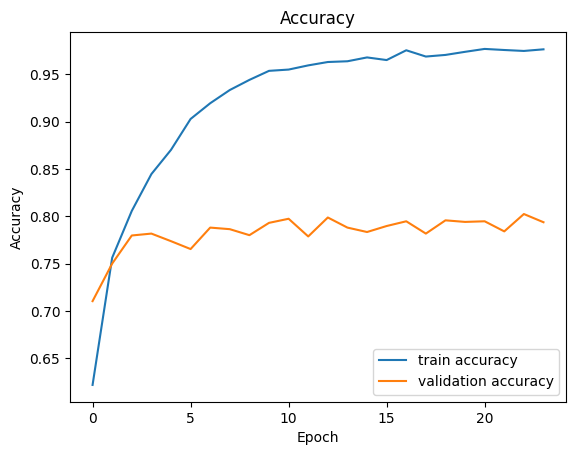

In [ ]:
plot_training_history(history_cnn)

1/1 [==============================] - 0s 24ms/step


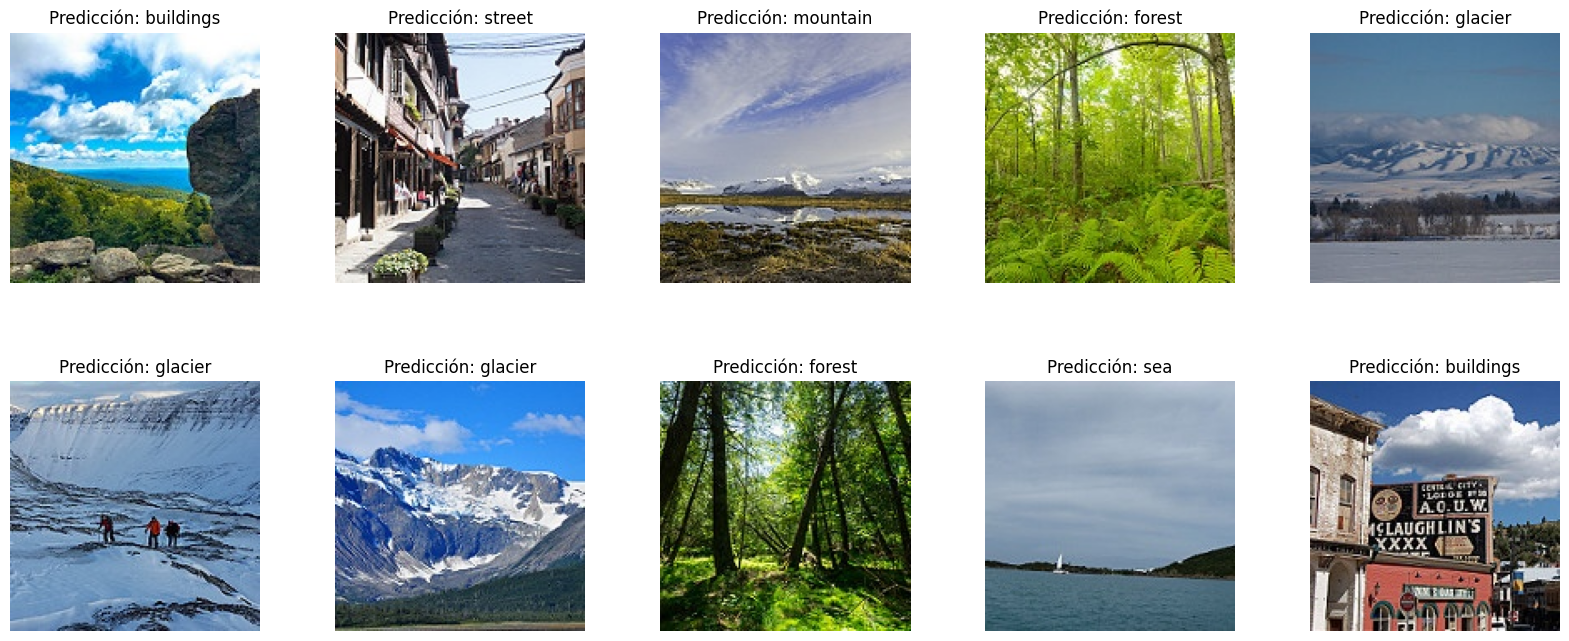

In [ ]:
predecir_y_mostrar_10_imagenes("/content/TP1-3/seg_pred/seg_pred",model_cnn)

## Modelo que incluya bloques residuales identidad:


In [ ]:
def identity_block(input_tensor, kernel_size, filters):
    filters1, filters2, filters3 = filters

    x = tf.keras.layers.Conv2D(filters1, (1, 1))(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters2, kernel_size, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters3, (1, 1))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.add([x, input_tensor])
    x = tf.keras.layers.Activation('relu')(x)
    return x



In [ ]:
def cnn_model_with_res_blocks(*, input_shape, labels):
    input_tensor = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Rescaling(1./255)(input_tensor)

    # Capas convolucionales y bloques residuales
    x = tf.keras.layers.Conv2D(8, (3, 3), padding='same')(x)
    x = identity_block(x, (3, 3), [8, 8, 8])
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(16, (3, 3), padding='same')(x)
    x = identity_block(x, (3, 3), [16, 16, 16])
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(x)
    x = identity_block(x, (3, 3), [32, 32, 32])
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(x)
    x = identity_block(x, (3, 3), [64, 64, 64])
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    # Capas densas
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(labels)(x)
    output = tf.keras.layers.Activation('softmax')(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=output)
    return model


In [ ]:
cnn_model_res=cnn_model_with_res_blocks(input_shape=(IMG_H,IMG_W,3),labels=len(train_dataset.class_names))
cnn_model_res.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 250, 250, 3)]        0         []                            
                                                                                                  
 rescaling_6 (Rescaling)     (None, 250, 250, 3)          0         ['input_6[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 250, 250, 8)          224       ['rescaling_6[0][0]']         
                                                                                                  
 conv2d_1 (Conv2D)           (None, 250, 250, 8)          72        ['conv2d[0][0]']              
                                                                                            

In [ ]:
cnn_model_res.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history_cnn_model_res=cnn_model_res.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=500,
    batch_size=BATCH_SIZE,
    callbacks=[EARLY_STOPPING,REDUCE_LR]
)

Epoch 1/500
439/439 [==============================] - 65s 116ms/step - loss: 1.0072 - accuracy: 0.6420 - val_loss: 1.0997 - val_accuracy: 0.5253 - lr: 0.0010
Epoch 2/500
439/439 [==============================] - 47s 107ms/step - loss: 0.7180 - accuracy: 0.7289 - val_loss: 0.8400 - val_accuracy: 0.6977 - lr: 0.0010
Epoch 3/500
439/439 [==============================] - 49s 111ms/step - loss: 0.6124 - accuracy: 0.7752 - val_loss: 0.7625 - val_accuracy: 0.7097 - lr: 0.0010
Epoch 4/500
439/439 [==============================] - 48s 110ms/step - loss: 0.5490 - accuracy: 0.7988 - val_loss: 0.8345 - val_accuracy: 0.6947 - lr: 0.0010
Epoch 5/500
439/439 [==============================] - 49s 110ms/step - loss: 0.4918 - accuracy: 0.8196 - val_loss: 0.7457 - val_accuracy: 0.7280 - lr: 0.0010
Epoch 6/500
439/439 [==============================] - 49s 111ms/step - loss: 0.4515 - accuracy: 0.8365 - val_loss: 0.6584 - val_accuracy: 0.7690 - lr: 0.0010
Epoch 7/500
439/439 [=========================

In [ ]:
print("Evaluate on test data")
results = cnn_model_res.evaluate(val_dataset, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

Evaluate on test data
94/94 [==============================] - 5s 50ms/step - loss: 0.9380 - accuracy: 0.7577
test loss, test acc: [0.9380347728729248, 0.7576666474342346]


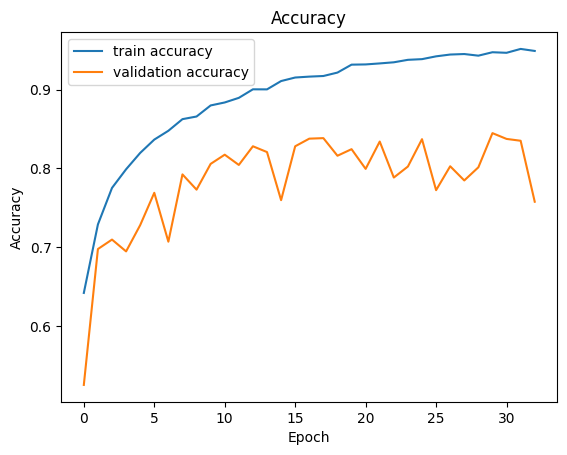

In [ ]:
plot_training_history(history_cnn_model_res)

In [ ]:
predecir_y_mostrar_10_imagenes("/content/TP1-3/seg_pred/seg_pred",cnn_model_res)

1/1 [==============================] - 0s 19ms/step


## Modelo Transfer Learning

In [ ]:
train_dataset=tf.keras.utils.image_dataset_from_directory(
    str(TRAIN_DATA_FOLDER),  # Convertir a cadena si es un objeto Path
    label_mode="categorical",
    image_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE
)

val_dataset=tf.keras.utils.image_dataset_from_directory(
    str(VAL_DATA_FOLDER),  # Convertir a cadena si es un objeto Path
    label_mode="categorical",
    image_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE
)


Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [ ]:
def transfered_learning_model(input_shape: Tuple[int], num_classes: int) -> tf.keras.Model:
    base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet')
    base_model.trainable = False

    i = Input(shape=input_shape)
    x = base_model(i, training=False)
    x = GlobalMaxPooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(i, x)



In [ ]:
tlm=transfered_learning_model(input_shape=(250,250,3),num_classes=6)´
tlm.summary()

In [ ]:
tlm.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

In [ ]:
history_tlm = tlm.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=150,
    batch_size=BATCH_SIZE,
    callbacks=[EARLY_STOPPING,REDUCE_LR]
)


Epoch 1/150
439/439 [==============================] - 42s 94ms/step - loss: 0.2411 - accuracy: 0.9190 - val_loss: 0.3777 - val_accuracy: 0.8920 - lr: 0.0010
Epoch 2/150
439/439 [==============================] - 43s 97ms/step - loss: 0.2256 - accuracy: 0.9248 - val_loss: 0.5451 - val_accuracy: 0.8670 - lr: 0.0010
Epoch 3/150
439/439 [==============================] - 42s 95ms/step - loss: 0.2187 - accuracy: 0.9247 - val_loss: 0.4577 - val_accuracy: 0.8870 - lr: 0.0010
Epoch 4/150
439/439 [==============================] - 44s 100ms/step - loss: 0.1892 - accuracy: 0.9356 - val_loss: 0.5979 - val_accuracy: 0.8543 - lr: 0.0010
Epoch 5/150
439/439 [==============================] - 42s 96ms/step - loss: 0.1951 - accuracy: 0.9354 - val_loss: 0.4550 - val_accuracy: 0.8863 - lr: 0.0010
Epoch 6/150
439/439 [==============================] - 45s 102ms/step - loss: 0.1823 - accuracy: 0.9382 - val_loss: 0.4278 - val_accuracy: 0.8903 - lr: 0.0010
Epoch 7/150
439/439 [=============================

In [ ]:
print("Evaluate on test data")
results = tlm.evaluate(val_dataset, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

Evaluate on test data
94/94 [==============================] - 10s 102ms/step - loss: 0.5356 - accuracy: 0.8900
test loss, test acc: [0.5355942249298096, 0.8899999856948853]


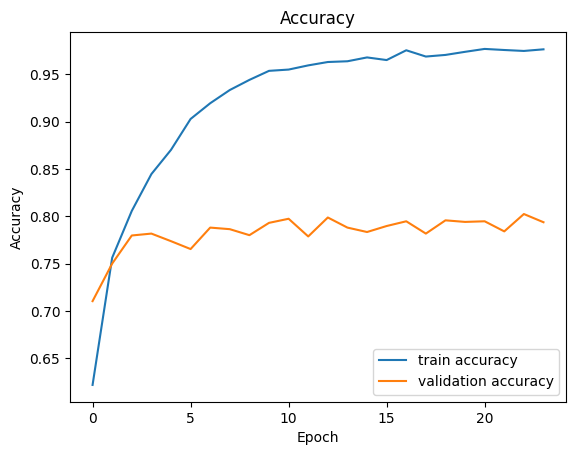

In [ ]:
plot_training_history(history_tlm)

In [ ]:
predecir_y_mostrar_10_imagenes("/content/TP1-3/seg_pred/seg_pred",tlm)

1/1 [==============================] - 0s 23ms/step
